# 15-minutes Realized Variance Notebook

This notebook analyzes the best subfrequency for computing the 15-minutes Realized Variance by creating a variance signature plot.

In [120]:
# Required libraries
# Required libraries
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from pathlib import Path
import sys
import os 
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import datetime
import zipfile 
from timeit import default_timer as timer
import sqlalchemy as db
import matplotlib.pylab as pylab
# Paths
sys.path.append(os.path.join(Path(os.getcwd()).parent))  
data_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'data')
data_per_day_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'data','data_per_day')
results_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'results')

# create connection to sqlite database
db_path = os.path.join(data_path, 'database.db')
db_engine = db.create_engine('sqlite:///' + db_path)

params = {
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [20]:
# get the data folders file now
data_folders = [f for f in os.listdir(data_per_day_path) if not os.path.isfile(os.path.join(data_per_day_path, f))]
data_folders = [file for file in data_folders if '.' not in file]
data_folders = [os.path.join(data_per_day_path, x) for x in data_folders]
# get the csv file now
data_folder = data_folders[1]
table_name = data_folder[-3:]
csv_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]
csv_files = [file for file in csv_files if '.csv' in file and '201912' in file]
csv_files = np.sort([os.path.join(data_folder, x) for x in csv_files])

In [21]:
def compute_second_data(csv_file):
    data_df = pd.read_csv(csv_file)
    data_df.DT = pd.to_datetime(data_df.DT)
    data_df.sort_values(by=['DT'], inplace=True)
    data_df.index = data_df.DT
    data_df.drop(columns=['DT'],inplace=True)
    data_df = data_df.between_time('9:30', '16:00')
    data_df.reset_index(drop=False, inplace=True)

    # non zero quotes
    data_df = data_df.loc[(data_df.BID>0) & (data_df.BIDSIZ>0) & (data_df.ASK>0) & (data_df.ASKSIZ>0)]

    # autoselect exchange
    data_df['total_size'] = data_df.BIDSIZ + data_df.ASKSIZ
    #data_df = data_df.loc[data_df.EX == data_df.groupby(['EX']).sum().total_size.idxmax()]

    # delete negative spreads
    data_df = data_df.loc[data_df.ASK > data_df.BID]

    # mergeQuotesSameTimestamp
    ex = data_df.EX.values[0]
    sym_root = data_df.SYM_ROOT.values[0]
    data_df.drop(columns=['SYM_SUFFIX', 'total_size'], inplace=True)
    data_df = data_df.groupby(['DT']).median()
    data_df['EX'] = ex
    data_df['SYM_ROOT'] = sym_root
    data_df.reset_index(drop=False, inplace=True)

    # remove entries with spread > 50 * daily median spread
    data_df['SPREAD'] = data_df.ASK - data_df.BID
    data_df = data_df.loc[data_df['SPREAD'] < 50 * data_df['SPREAD'].median()]

    # remove outliers using the centered rolling window approach 
    def compute_diff(x):
        return x.values[window] - np.median(np.delete(x.values,window))

    window = 25
    data_df.sort_values(by=['DT'], inplace=True)
    data_df['SPREAD_DIFF'] = data_df.SPREAD.rolling(2*window+1, min_periods=2*window+1, center=True).apply(compute_diff)
    data_df = data_df.loc[(data_df['SPREAD_DIFF'] < 10 * data_df['SPREAD_DIFF'].mean()) | (data_df['SPREAD_DIFF'].isna())]
    data_df = data_df.reset_index(drop=True)
    
    # resample data to 15 seconds level
    data_df.set_index(['DT'], inplace=True)
    data_df["MID"] = data_df.apply(lambda x: (x.ASK * x.ASKSIZ + x.BID * x.BIDSIZ) / (x.ASKSIZ + x.BIDSIZ), axis=1)
    data_df = data_df[['MID', 'SYM_ROOT']]
    df_resampled = data_df.resample('1s').ffill()
    df_resampled = df_resampled.append(pd.DataFrame(data_df[-1:].values, 
                                                    index=[df_resampled.index[-1] + datetime.timedelta(seconds=1)],columns=data_df.columns)) # get last observation that is not added by ffill
    # set new index and forward fill the price data
    
    first_date = datetime.datetime(year=2019,month=12,day=int(csv_file[-6:-4]),hour=9,minute=45,second=0)
    df_resampled = df_resampled.iloc[1:,:] # observation at 9:30 is going to be NA
    new_index = pd.date_range(start=first_date, periods=22501, freq='1s') # index from 9:45 until 16:00
    df_resampled = df_resampled.reindex(new_index, method='ffill')
    df_resampled.reset_index(drop=False, inplace=True)
    df_resampled.rename(columns={'index': 'DT'}, inplace = True)

    return df_resampled

In [4]:
%%time
from joblib import Parallel, delayed
    
df_data_all_days_SPY = Parallel(n_jobs=14)(delayed(compute_second_data)(i) for i in csv_files)

CPU times: user 97.7 ms, sys: 43.9 ms, total: 142 ms
Wall time: 14min 34s


In [16]:
%%time
from joblib import Parallel, delayed
    
df_data_all_days_EEM = Parallel(n_jobs=14)(delayed(compute_second_data)(i) for i in csv_files)

CPU times: user 53.8 ms, sys: 47.3 ms, total: 101 ms
Wall time: 3min 3s


In [22]:
%%time
from joblib import Parallel, delayed
    
df_data_all_days_EZU = Parallel(n_jobs=14)(delayed(compute_second_data)(i) for i in csv_files)

CPU times: user 69.8 ms, sys: 5.67 ms, total: 75.5 ms
Wall time: 59.8 s


# Analysis best sampling for 15min realized variance

The result indicates that 1min is more than enough

In [57]:
def compute_rv(df, sampling):
    df.index = df.DT
    df_resampled = df.resample(sampling).ffill()
    df_resampled['RET'] = df_resampled.MID.pct_change().apply(np.vectorize(lambda x: np.log(1+x)))
    df_resampled = df_resampled.iloc[1:,:] # first return is NA
    df_resampled.reset_index(drop=True, inplace=True)
    df_resampled['RET2'] = df_resampled['RET'].apply(lambda x: x ** 2)
    df_resampled.iloc[-1,0] = df_resampled.iloc[-1,0] - datetime.timedelta(seconds=1)
    df_resampled.index = df_resampled.DT
    df_resampled = df_resampled.resample('15min').sum()
    df_resampled.reset_index(drop=False, inplace=True)
    df_resampled.DT = df_resampled.DT + datetime.timedelta(minutes=15)
    return list(df_resampled['RET2'].values)

In [62]:
samplings = ['1s', '2s', '5s', '10s', '20s', '30s', '40s', '50s', '1min','3min', '5min']
rv_plot = []
for sampling in samplings:
    rv_sample = []
    for df in df_data_all_days_SPY:
        rv_sample +=compute_rv(df, sampling)
    rv_plot.append(np.mean(rv_sample))

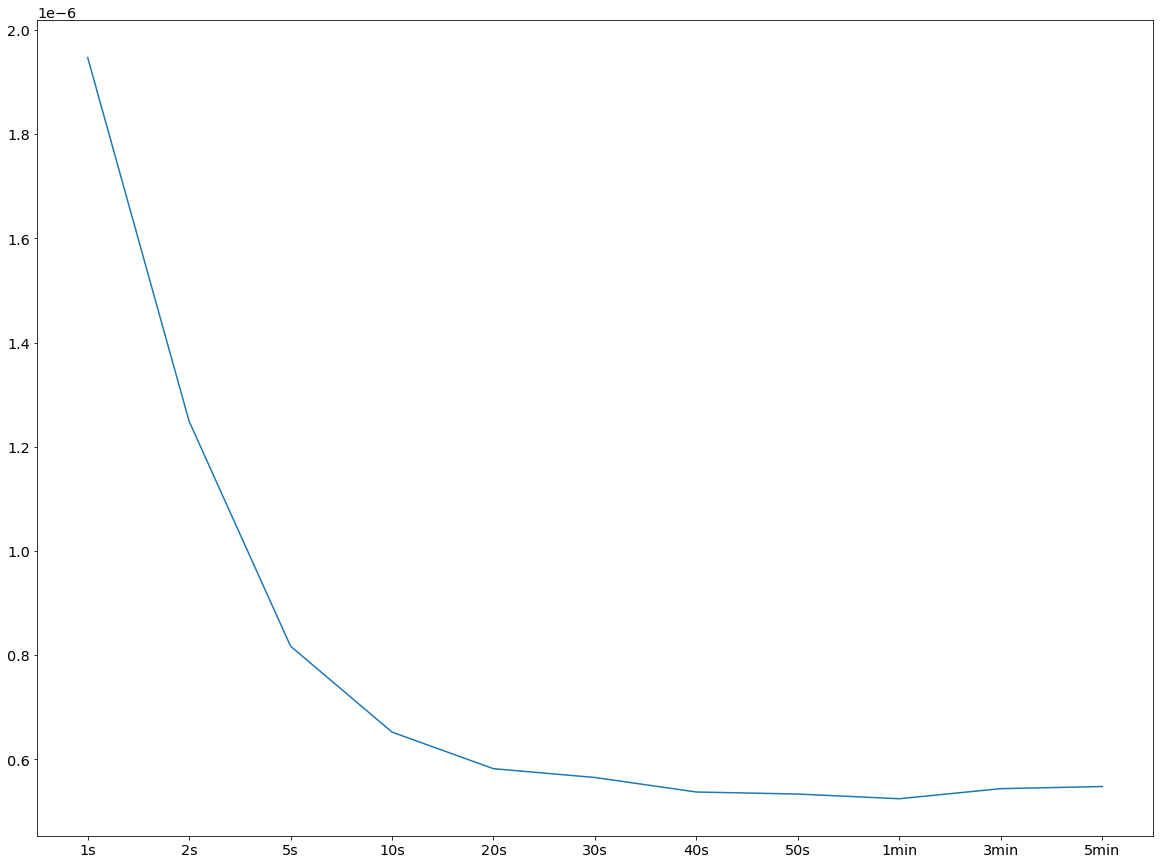

In [121]:
fig,ax = plt.subplots(1,1,figsize=(20,15))
plt.plot(samplings, rv_plot)
plt.savefig(os.path.join(results_path, 'rv_15_signature_plot.png'), dpi=400, facecolor='aliceblue',edgecolor='k',bbox_inches='tight')
plt.show()

In [110]:
df_test = pd.DataFrame(columns=['varEEM', 'varSPY', 'varEZU', 'cov(EEM,SPY)', 'cov(EEM, EZU)', 'cov(SPY, EZU)'])
for day in range(len(df_data_all_days_SPY)):
    df_SPY = df_data_all_days_SPY[day]
    df_SPY.index = df_SPY.DT
    df_SPY = df_SPY.resample('1min').ffill()
    df_SPY['RET'] = df_SPY.MID.pct_change().apply(np.vectorize(lambda x: np.log(1+x)))
    df_SPY = df_SPY[1:]

    df_EEM = df_data_all_days_EEM[day]
    df_EEM.index = df_EEM.DT
    df_EEM = df_EEM.resample('1min').ffill()
    df_EEM['RET'] = df_EEM.MID.pct_change().apply(np.vectorize(lambda x: np.log(1+x)))
    df_EEM = df_EEM[1:]

    df_EZU = df_data_all_days_EZU[day]
    df_EZU.index = df_EZU.DT
    df_EZU = df_EZU.resample('1min').ffill()
    df_EZU['RET'] = df_EZU.MID.pct_change().apply(np.vectorize(lambda x: np.log(1+x)))
    df_EZU = df_EZU[1:]

    master_df = pd.DataFrame(index = df_SPY.index, columns=['varEEM', 'varSPY', 'varEZU', 'cov(EEM,SPY)', 'cov(EEM, EZU)', 'cov(SPY, EZU)'])
    master_df['varEEM'] = df_EEM.RET.apply(lambda x: x**2)
    master_df['varSPY'] = df_SPY.RET.apply(lambda x: x**2)
    master_df['varEZU'] = df_EZU.RET.apply(lambda x: x**2)
    master_df['cov(EEM,SPY)'] = np.multiply(df_EEM.RET.values, df_SPY.RET.values)
    master_df['cov(EEM, EZU)'] = np.multiply(df_EEM.RET.values, df_EZU.RET.values)
    master_df['cov(SPY, EZU)'] = np.multiply(df_SPY.RET.values, df_EZU.RET.values)
    master_df.reset_index(drop=False, inplace=True)
    master_df.iloc[-1,0] = master_df.iloc[-1,0] - datetime.timedelta(seconds=1)
    master_df.index = master_df.DT
    master_df = master_df.resample('15min').sum()
    master_df.reset_index(drop=False, inplace=True)
    master_df.DT = master_df.DT + datetime.timedelta(minutes=15)
    df_test = pd.concat([df_test, master_df])

In [112]:
df_test.to_excel(os.path.join(data_path, 'RV15min.xlsx'))